# Gaussian Mixture Model

This is a brief tutorial on training mixture models in Pyro. We'll focus on the mechanics of `config_enumerate()` and setting up mixture weights. To simplify matters, we'll train a trivial 1-D Gaussian model on a tiny 5-point dataset.

In [1]:
from __future__ import print_function
import os
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints, transform_to
from matplotlib import pyplot
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro.optim import Adam
from pyro.infer import SVI, config_enumerate
smoke_test = ('CI' in os.environ)

# Replace this with transform_to(constrains.simplex) after
# https://github.com/pytorch/pytorch/pull/5842
from torch.nn import Softmax
softmax = Softmax(dim=-1)

## Dataset

Here is our tiny dataset. It has five points.

In [2]:
data = torch.tensor([0, 1, 10, 11, 12])

## Maximum likelihood approach

Let's start by optimizing model parameters `weights`, `locs`, and `scale`, rather than treating them as random variables with priors. Our model will learn global mixture weights, the location of each mixture component, and a shared scale that is common to both components. Our guide will learn soft assignment weights of each point.

Note that none of our parameters have priors. In this Maximum Likelihood approach we can embed our parameters directly in the model rather than the guide. This is equivalent to adding them in the guide as `pyro.sample(..., dist.Delta(...))` sites and using a uniform prior in the model.

In [3]:
K = 2  # Fixed number of components.

def model(data):
    # Global parameters.
    weights = softmax(pyro.param('unconstrained_weights', torch.zeros(K, requires_grad=True)))
    locs = pyro.param('locs', torch.tensor(10 * torch.randn(K), requires_grad=True))
    scale = transform_to(constraints.positive)(
        pyro.param('unconstrained_scale', torch.tensor(-1, requires_grad=True)))

    with pyro.iarange('data'):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights).reshape([len(data)]))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

def guide(data):
    with pyro.iarange('data'):
        # Local parameters.
        assignment_probs = transform_to(constraints.positive)(
            pyro.param('unconstrained_assignment_probs',
                       torch.zeros(len(data), K, requires_grad=True)))
        pyro.sample('assignment', dist.Categorical(assignment_probs))

To run inference with this `(model,guide)` pair, we use Pyro's `config_enumerate()` function to enumerate over all assignments in each iteration. Since we've wrapped the batched Categorical assignments in a `pyro.iarange` indepencence context, this enumeration can happen in parallel: we enumerate only 2 possibilites, rather than `2**len(data) = 32`. Finally, to use the parallel version of enumeration, we inform pyro that we're only using a single `iarange` via `max_iarange_nesting=1`; this lets Pyro know that we're using the rightmost dimension `iarange` and letting use any other dimension for parallelization.

In [4]:
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.9, 0.99]})
inference = SVI(model, config_enumerate(guide, 'parallel'), optim, 'ELBO',
                enum_discrete=True, max_iarange_nesting=1)

In [5]:
pyro.set_rng_seed(0)      # Set seed to make results reproducible.
pyro.clear_param_store()  # Clear stale param values.
losses = []
for i in range(500 if not smoke_test else 2):
    loss = inference.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................
...................................................................................................

Text(0.5,1,u'Convergence of SVI')

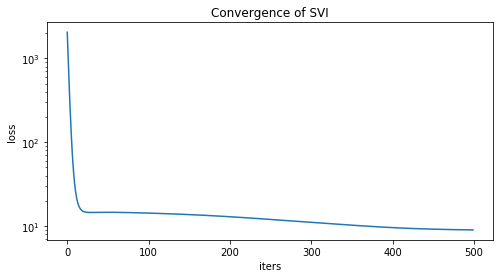

In [6]:
pyplot.figure(figsize=(8,4)).set_facecolor('white')
pyplot.plot(losses)
pyplot.xlabel('iters')
pyplot.ylabel('loss')
pyplot.yscale('log')
pyplot.title('Convergence of SVI')

Here are the learned parameters:

In [7]:
weights = softmax(pyro.param('unconstrained_weights'))
locs = pyro.param('locs')
scale = transform_to(constraints.positive)(pyro.param('unconstrained_scale'))
print('weights = {}'.format(weights.data.numpy()))
print('locs = {}'.format(locs.data.numpy()))
print('scale = {}'.format(scale.data.numpy()))

weights = [0.6005184  0.39948162]
locs = [10.996018   0.5074739]
scale = 0.755260825157


The model's `weights` are as expected, with 3/5 of the data in the first component and 2/3 in the second component. We can also examine the guide's local `assignment_probs` variable.

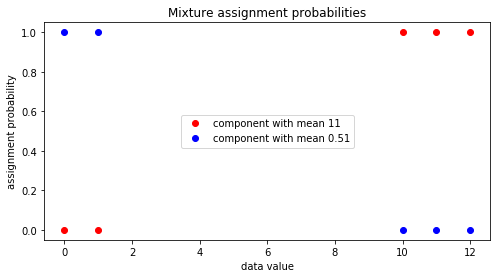

In [8]:
assignment_probs = softmax(pyro.param('unconstrained_assignment_probs'))
pyplot.figure(figsize=(8, 4)).set_facecolor('white')
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 0], 'ro',
            label='component with mean {:0.2g}'.format(locs[0]))
pyplot.plot(data.data.numpy(), assignment_probs.data.numpy()[:, 1], 'bo',
            label='component with mean {:0.2g}'.format(locs[1]))
pyplot.title('Mixture assignment probabilities')
pyplot.xlabel('data value')
pyplot.ylabel('assignment probability')
pyplot.legend(loc='center');

Next let's visualize the mixture model.

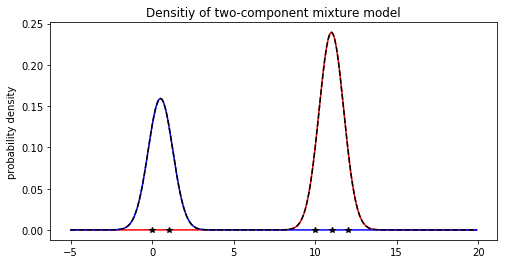

In [9]:
X = np.arange(-5,20,0.1)
Y1 = weights[0].item() * scipy.stats.norm.pdf((X - locs[0].item()) / scale.item())
Y2 = weights[1].item() * scipy.stats.norm.pdf((X - locs[1].item()) / scale.item())

pyplot.figure(figsize=(8, 4)).set_facecolor('white')
pyplot.plot(X, Y1, 'r-')
pyplot.plot(X, Y2, 'b-')
pyplot.plot(X, Y1 + Y2, 'k--')
pyplot.plot(data.data.numpy(), np.zeros(len(data)), 'k*')
pyplot.title('Densitiy of two-component mixture model')
pyplot.ylabel('probability density');

Finally note that optimization with mixture models is non-convex and can often get stuck in local optima. For example in this tutorial, we observed that the mixture model gets stuck in an everthing-in-one-cluster hypothesis if `scale` is initialized to be too large.